# 2.5D IP Forward Simulation

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

**Author:** Devin C. Cowan

</br>

**Keywords:** Induced polarization, 2.5D forward simulation, apparent chargeability, tree mesh.

</br>

**Summary:** Here, we use the [simpeg.electromagnetics.static.induced_polarization](myst:simpeg#simpeg.electromagnetics.static.induced_polarization) module to simulate 2.5D DC induced polarization (IP) data on a tree mesh. This approach is ideal when the local geology doesn't change along the strike direction, as we can leverage the symmetry of the problem to reduce computational cost.

Because the same survey geometry, mesh and topography that are used to simulate DC resistivity data are used simulate IP data, almost all of the fundamental functionality used in this tutorial is described in detail in the [2.5D Forward Simulation of DC Resistivity Data](../05-dcr/fwd_dcr_2d.ipynb) tutorial. In this tutorial, we focus primarily on functionality related to the simulation of IP data. More specifically, we discuss:

- Defining the chargeability model
- How to simulate IP data
- Units of the apparent chargeability model and predicted data

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to IP is imported from [simpeg.electromagnetics.static.induced_polarization](myst:simpeg#simpeg.electromagnetics.static.induced_polarization).
We also import some useful utility functions from [simpeg.utils](myst:simpeg#simpeg.utils). To simulate DC and IP data, we need to define our problem geometry on a numerical grid (or mesh).
To generate the mesh, we used the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from simpeg.electromagnetics.static import induced_polarization as ip
from simpeg.utils import model_builder
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc
from simpeg import maps, data
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

# Common Python functionality
import os
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

mpl.rcParams.update({"font.size": 14})

write_output = False  # Optional

## Define the Topography

True surface topography is defined as an (N, 3) [numpy.ndarray](myst:numpy#numpy.ndarray).
For use in a 2.5D simulation however, topography is defined as an (N, 2) [numpy.ndarray](myst:numpy#numpy.ndarray), where the first coordinate represent along-line position and the second coordinate represents the vertical position. Here, we define the 2D topography used for the 2.5D simulation.

In [2]:
# Along-line locations
x_topo = np.linspace(-2000, 2000, 401)

# Elevation as a function of along-line location
T = 800.0
z_topo = 20.0 * np.sin(2 * np.pi * x_topo / T) + 140.0
z_topo[x_topo < -3 * T / 4] = 160.0
z_topo[x_topo > 3 * T / 4] = 120.0
z_topo += 50.0 * (1.0 + np.tanh(-3 * (x_topo + 1200.0) / T))
z_topo -= 50.0 * (1.0 + np.tanh(3 * (x_topo - 1200.0) / T))

# Define full 2D topography
topo_2d = np.c_[x_topo, z_topo]

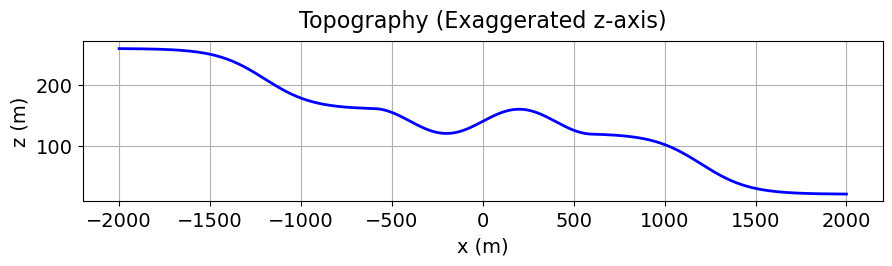

In [3]:
# Plot 2D topography
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x_topo, z_topo, color="b", linewidth=2)
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=10)
plt.show(fig)

## Define the IP Survey

A full description of elements required to define DC and IP surveys was presented in the [2.5D Forward Simulation of DC Resistivity Data](../05-dcr/fwd_dcr_2d.ipynb) tutorial. Here, we take the same approach. The only difference is that our receivers are defined to measure apparent chargeabilities. Because SimPEG uses a linearized formulation for simulating IP data; see [Simulation2DCellCentered](myst:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation2DCellCentered) or [Simulation2DNodal](myst:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation2DNodal), the units of the apparent chargeability data are the same as the units chosen to represent the subsurface chargeabilities.

The survey line is an 800 m long EW dipole-dipole line with an electrode spacing of 40 m. There is a maximum of 10 potential electrodes per current electrode.

In [4]:
# Define survey line parameters
survey_type = "dipole-dipole"
dimension_type = "2D"
data_type = "apparent_chargeability"
end_locations = np.r_[-400.0, 400.0]
station_separation = 40.0
num_rx_per_src = 10

In [5]:
ip_source_list = generate_dcip_sources_line(
    survey_type,
    data_type,
    dimension_type,
    end_locations,
    topo_2d,
    num_rx_per_src,
    station_separation,
)

ip_survey = ip.survey.Survey(ip_source_list)

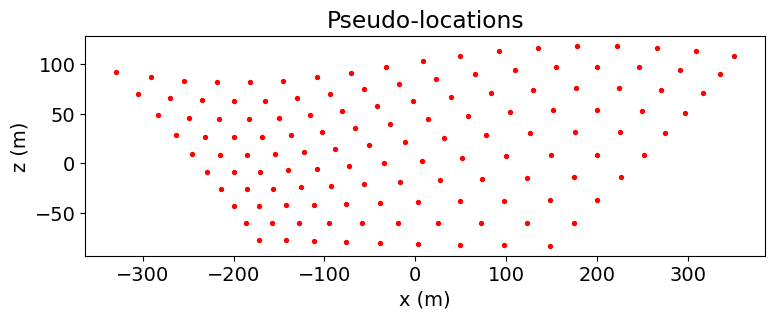

In [6]:
pseudo_locations_xz = pseudo_locations(ip_survey)
fig = plt.figure(figsize=(8, 2.75))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])
ax.scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], 8, "r")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("Pseudo-locations")
plt.show()

## Design a (Tree) Mesh

Here, we generate a tree mesh based on the survey geometry. The best-practice approach for generating meshes for DC/IP simulations is provided in the [2.5D Forward Simulation of DC Resistivity Data](../05-dcr/fwd_dcr_2d.ipynb) tutorial.

In [7]:
dh = 4  # base cell width
dom_width_x = 3200.0  # domain width x
dom_width_z = 2400.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh with top at z = 0 m.
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN")

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, z_topo.max()]

# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d,
    padding_cells_by_level=[0, 0, 4, 4],
    finalize=False,
)

# Extract unique electrode locations.
unique_locations = ip_survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[8, 12, 6, 6], finalize=False
)

mesh.finalize()

## Define the Active Cells

Use the [active_from_xyz](myst:discretize#discretize.utils.active_from_xyz) utility function to obtain the indices of the active mesh cells from topography (e.g. cells below surface).

In [8]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_2d)

# number of active cells
n_active = np.sum(active_cells)

## Define the Background Conductivity/Resistivity

In order to simulate IP data, we require the background conductivity/resistivity defined on the entire mesh. You can generate this directly, or apply the appropriate mapping to a different parameterization of the conductivity/resistivity. 

For the tutorial, we generate the conductivity model that was used for the [2.5D Forward Simulation of DC Resistivity Data](../05-dcr/fwd_dcr_2d.ipynb) tutorial; i.e. the electrical conductivities of all active cells. And so we must use the [simpeg.maps.InjectActiveCells](myst:simpeg#simpeg.maps.InjectActiveCells) mapping to map from the model space to the conductivities on the entire mesh.

In [9]:
# Define electrical conductivities in S/m
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

In [10]:
# Define conductivity model
conductivity_model = background_conductivity * np.ones(n_active)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-120.0, 40.0], 60.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_conductor] = conductor_conductivity

ind_resistor = model_builder.get_indices_sphere(
    np.r_[120.0, 72.0], 60.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_resistor] = resistor_conductivity

In [11]:
# Mapping from conductivity model to mesh
conductivity_map = maps.InjectActiveCells(mesh, active_cells, air_conductivity)

In [12]:
# Mapping to neglect air cells when plotting
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

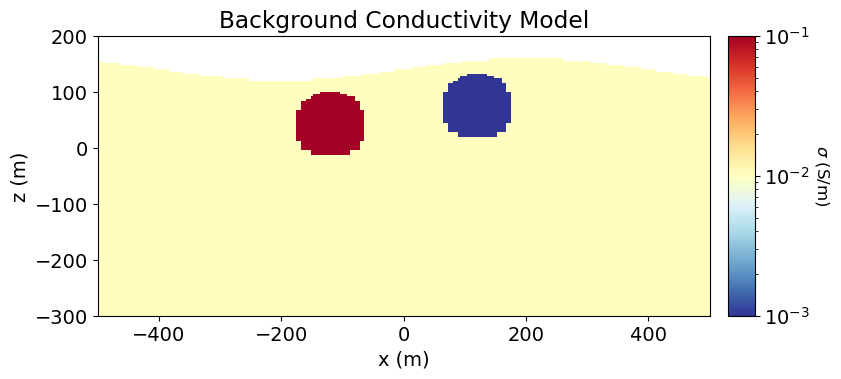

In [13]:
fig = plt.figure(figsize=(9, 4))
norm = LogNorm(vmin=1e-3, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_xlim(-500, 500)
ax1.set_ylim(-300, 200)
ax1.set_title("Background Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()

## Define the Chargeability Model and Mapping

The model does not need to be synonymous with the physical property values. But it is common to define chargeability models as the chargeabilities for all subsurface (active) cells. So, what are the units?

SimPEG uses a linearized formulation for simulating IP data; see [Simulation2DCellCentered](myst:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation2DCellCentered) or [Simulation2DNodal](myst:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation2DNodal). In this formulation, any standard definition of the chargeability can be used. And the resulting apparent chargeability data will be in terms of the same units; e.g. intrinsic chargeability (V/V or mV/V) or integrated chargeability (ms). If you are simulating secondary voltages, the chargeability model must represent intrinsic chargeabilities ($0 \leq \eta \leq 1$) in V/V.

For this tutorial, we use the intrinsic chargeability in units V/V. Here, the conductive sphere is chargeable, but the resistive sphere and the host are not. Note that unlike DC resistivity, the physical property value defining air cells for IP simulation can be set to zero.

In [14]:
# Intrinsic chargeability in V/V (unitless).
air_chargeability = 0.0
background_chargeability = 0.0
sphere_chargeability = 1e-1

In [15]:
# Define chargeability model
chargeability_model = background_chargeability * np.ones(n_active)

ind_chargeable = model_builder.get_indices_sphere(
    np.r_[-120.0, 40.0], 60.0, mesh.cell_centers[active_cells, :]
)
chargeability_model[ind_chargeable] = sphere_chargeability

In [16]:
# Define mapping for chargeability
chargeability_map = maps.InjectActiveCells(mesh, active_cells, air_chargeability)

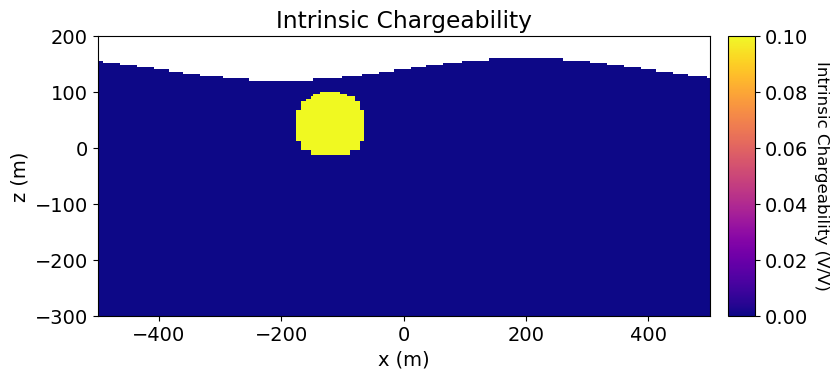

In [17]:
# Plot Chargeability Model
fig = plt.figure(figsize=(9, 4))

norm = Normalize(vmin=0.0, vmax=0.1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * chargeability_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
)
ax1.set_xlim(-500, 500)
ax1.set_ylim(-300, 200)
ax1.set_title("Intrinsic Chargeability")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("Intrinsic Chargeability (V/V)", rotation=270, labelpad=15, size=12)

plt.show()

## Project Electrodes to Discretized Topography

As explained in the [2.5D Forward Simulation of DC Resistivity Data](../05-dcr/fwd_dcr_2d.ipynb) tutorial, we use the [drape_electrodes_on_topography](myst:simpeg#simpeg.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography) method to project the electrodes to the discrete surface topography.

In [18]:
ip_survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Define the IP Simulation

There are two simulation classes which may be used to simulate 2.5D IP data:

- [Simulation2DNodel](myst:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation2DNodal), which defines the discrete electric potentials on mesh nodes.
- [Simulation2DCellCentered](myst:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation2DCellCentered), which defines the discrete electric potentials at cell centers.

For surface DC and IP data, the nodal formulation is more well-suited and will be used here. The cell-centered formulation works well for simulating borehole DC and IP data. To fully define the forward simulation, we need to connect the simulation object to:

- the survey
- the mesh
- a background conductivity or resistivity model
- the mapping from the chargeability model to the mesh

If working with electrical conductivity, use the ``sigma`` keyword argument to define the background conductivity on the entire mesh. If working with electrical resistivity, use the ``rho`` keyword argument to define the background resistivity on the entire mesh. The ``etaMap`` is used to define the mapping from the chargeability model to the chargeabilities on the entire mesh.

In [19]:
ip_simulation = ip.Simulation2DNodal(
    mesh,
    survey=ip_survey,
    etaMap=chargeability_map,
    sigma=conductivity_map * conductivity_model,
)

## Simulate IP Data

In [20]:
dpred_ip = ip_simulation.dpred(chargeability_model)

/home/ssoler/mambaforge/envs/simpeg-user-tutorials/lib/python3.10/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/home/ssoler/mambaforge/envs/simpeg-user-tutorials/lib/python3.10/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:783: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


## Plot IP Data in Pseudosection

Here we use the [plot_pseudosection](simpeg#simpeg.electromagnetics.static.utils.plot_pseudosection) utility function to represent predicted data on pseudosection plots.

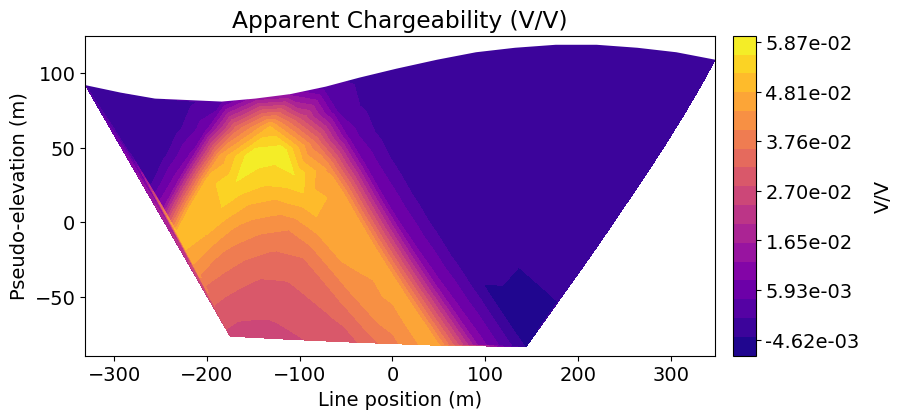

In [21]:
fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.8])
cax1 = fig.add_axes([0.82, 0.1, 0.025, 0.8])
plot_pseudosection(
    ip_survey,
    dpred_ip,
    "contourf",
    ax=ax1,
    cax=cax1,
    scale="linear",
    cbar_label="V/V",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.plasma},
)
ax1.set_title("Apparent Chargeability (V/V)")

plt.show()

**Optional:** Write data and topography

In [22]:
if write_output:
    dir_path = os.path.sep.join([".", "fwd_ip_2d_outputs"]) + os.path.sep
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    # Add 5% Gaussian noise to each datum
    np.random.seed(225)
    std = 5e-3 * np.ones_like(dpred_ip)
    ip_noise = std * np.random.normal(size=len(dpred_ip))
    dobs = dpred_ip + ip_noise

    # Create a survey with the original electrode locations
    # and not the shifted ones
    # Generate source list for DC survey line
    source_list = generate_dcip_sources_line(
        survey_type,
        data_type,
        dimension_type,
        end_locations,
        topo_2d,
        num_rx_per_src,
        station_separation,
    )
    survey_original = ip.survey.Survey(source_list)

    # Write out data at their original electrode locations (not shifted)
    data_obj = data.Data(survey_original, dobs=dobs, standard_deviation=std)
    fname = dir_path + "ip_data.obs"
    write_dcip2d_ubc(fname, data_obj, "apparent_chargeability", "dobs")

    fname = dir_path + "topo_2d.txt"
    np.savetxt(fname, topo_2d, fmt="%.4e")